In [1]:
!apt install cuda
!pip install pytorch_forecasting

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cuda-11-7 cuda-cccl-11-7 cuda-command-line-tools-11-7 cuda-compiler-11-7
  cuda-cudart-11-7 cuda-cudart-dev-11-7 cuda-cuobjdump-11-7 cuda-cupti-11-7
  cuda-cupti-dev-11-7 cuda-cuxxfilt-11-7 cuda-demo-suite-11-7
  cuda-documentation-11-7 cuda-driver-dev-11-7 cuda-gdb-11-7
  cuda-libraries-11-7 cuda-libraries-dev-11-7 cuda-memcheck-11-7
  cuda-nsight-11-7 cuda-nsight-compute-11-7 cuda-nsight-systems-11-7
  cuda-nvcc-11-7 cuda-nvdisasm-11-7 cuda-nvml-dev-11-7 cuda-nvprof-11-7
  cuda-nvprune-11-7 cuda-nvrtc-11-7 cuda-nvrtc-dev-11-7 cuda-nvtx-11-7
  cuda-nvvp-11-7 cuda-runtime-11-7 cuda-sanitizer-11-7 cuda-toolkit-11-7
  cuda-toolkit-11-7-config-common cuda-toolkit-11-config-common
  cuda-toolkit-config-common

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [3]:
import os
import json
import zipfile
import time
import itertools

import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import numpy as np

plt.style.use('seaborn')
import random

import math
import pdb

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep 13 16:33:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
travel_time_df = pd.read_csv('/content/drive/MyDrive/CIS 545 Project Folder/Data Set/2021_travel_time.csv')
corridor_file = "/content/drive/MyDrive/CIS 545 Project Folder/Data Set/pems_district4_corridors.csv"
corridor_df = pd.read_csv(corridor_file)

travel_time_df = travel_time_df[travel_time_df['5 Minutes'] > '2021-01-01 00:00:00']

In [7]:
corridors_to_merge = []

for row_num, corridor in corridor_df.iterrows():  	
      if row_num == 0:
          all_corridors_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
      else:
          corridor_tt_2021 = travel_time_df[(travel_time_df['corridor_name'] == corridor["Corridor"])	&  (travel_time_df['direction'] == corridor["Fwy-Dir"])][["5 Minutes",	"Mainline Agg"]]
          if corridor_tt_2021['5 Minutes'].duplicated().any() :
            print(corridor["Corridor"], " ", corridor["Fwy-Dir"])
            continue
          all_corridors_tt_2021 = all_corridors_tt_2021.merge(corridor_tt_2021, "outer", left_on='5 Minutes', right_on='5 Minutes')

02: I-580   I580-W
31: Hwy 101   US101-S
31: Hwy 101   US101-S


In [8]:
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg
0,2021-01-27 00:00:00,10.95,11.57,NaN,NaN,5.32,3.82,3.78,6.65,6.78,...,5.73,5.85,15.90,15.77,15.85,15.97,11.68,11.65,NaN,NaN
1,2021-01-27 00:05:00,11.00,11.62,NaN,NaN,5.33,3.87,3.93,6.68,6.92,...,5.78,5.85,15.97,15.83,16.07,16.05,12.12,11.63,NaN,NaN
2,2021-01-27 00:10:00,11.00,11.63,NaN,NaN,5.42,4.00,4.03,6.70,7.08,...,5.80,5.83,16.00,15.88,16.25,16.17,12.05,11.68,NaN,NaN
3,2021-01-27 00:15:00,11.00,11.63,NaN,NaN,5.45,4.07,4.13,6.68,7.07,...,5.85,5.85,16.02,15.98,16.25,16.18,12.13,11.68,NaN,NaN
4,2021-01-27 00:20:00,10.97,11.68,NaN,NaN,5.40,4.10,4.23,6.73,6.93,...,5.82,6.20,16.12,15.93,16.23,16.17,12.07,11.67,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77743,2021-10-31 23:35:00,10.93,11.63,NaN,NaN,NaN,4.00,3.83,6.57,6.78,...,5.75,5.92,15.73,15.82,15.95,15.32,11.67,11.23,NaN,NaN
77744,2021-10-31 23:40:00,10.92,11.63,NaN,NaN,NaN,4.03,3.77,6.57,6.75,...,5.73,5.92,15.73,15.90,15.90,15.40,11.82,11.28,NaN,NaN
77745,2021-10-31 23:45:00,10.88,11.62,NaN,NaN,NaN,4.05,3.78,6.52,6.70,...,5.73,5.90,15.75,15.85,15.82,15.55,11.75,11.40,NaN,NaN
77746,2021-10-31 23:50:00,10.88,11.60,NaN,NaN,NaN,3.95,3.85,6.55,6.75,...,5.73,6.03,15.73,15.75,15.63,15.75,11.67,11.55,NaN,NaN


In [9]:
all_corridors_tt_2021 = all_corridors_tt_2021.dropna(axis=1)
all_corridors_tt_2021

,5 Minutes,Mainline Agg_x,Mainline Agg_y,Mainline Agg_y,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,...,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x,Mainline Agg_y,Mainline Agg_x
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77743,2021-10-31 23:35:00,10.93,11.63,10.82,4.12,4.08,1.27,1.30,13.12,15.40,...,14.00,13.97,18.42,18.78,25.77,25.60,5.75,5.92,15.73,15.82
77744,2021-10-31 23:40:00,10.92,11.63,10.83,4.13,4.08,1.25,1.32,13.08,15.50,...,14.00,13.97,18.40,18.82,25.77,25.82,5.73,5.92,15.73,15.90
77745,2021-10-31 23:45:00,10.88,11.62,10.93,4.13,4.08,1.28,1.30,13.05,15.25,...,14.00,13.95,18.40,18.82,25.82,25.73,5.73,5.90,15.75,15.85
77746,2021-10-31 23:50:00,10.88,11.60,10.83,4.13,4.07,1.27,1.30,13.03,14.87,...,13.98,13.97,18.40,18.83,25.80,25.60,5.73,6.03,15.73,15.75


In [10]:
new_columns = [f"travel_time_{n}" for n in range(len(all_corridors_tt_2021.columns) - 1)]
new_columns.insert(0, "timestamp")
# len(new_columns)
all_corridors_tt_2021 = all_corridors_tt_2021.set_axis(new_columns, axis=1, inplace=False)
num_records, num_corridors = all_corridors_tt_2021.shape

In [11]:
all_corridors_tt_2021.head(10)

,timestamp,travel_time_0,travel_time_1,travel_time_2,travel_time_3,travel_time_4,travel_time_5,travel_time_6,travel_time_7,travel_time_8,...,travel_time_30,travel_time_31,travel_time_32,travel_time_33,travel_time_34,travel_time_35,travel_time_36,travel_time_37,travel_time_38,travel_time_39
0,2021-01-27 00:00:00,10.95,11.57,10.92,4.07,4.03,1.25,1.27,13.15,13.13,...,13.97,13.83,18.43,18.73,25.93,25.72,5.73,5.85,15.90,15.77
1,2021-01-27 00:05:00,11.00,11.62,10.93,4.15,4.05,1.27,1.27,13.20,13.12,...,13.97,13.85,18.47,18.75,26.15,25.68,5.78,5.85,15.97,15.83
2,2021-01-27 00:10:00,11.00,11.63,10.93,4.20,4.20,1.28,1.27,13.35,13.12,...,13.97,13.87,18.47,18.75,26.18,25.73,5.80,5.83,16.00,15.88
3,2021-01-27 00:15:00,11.00,11.63,10.93,4.17,4.13,1.28,1.27,13.35,13.10,...,13.95,13.87,18.47,18.73,26.02,25.87,5.85,5.85,16.02,15.98
4,2021-01-27 00:20:00,10.97,11.68,11.02,4.15,4.13,1.27,1.27,13.33,13.12,...,13.95,13.85,18.45,18.72,26.03,25.80,5.82,6.20,16.12,15.93
5,2021-01-27 00:25:00,11.00,11.70,11.15,4.13,4.28,1.27,1.27,13.35,13.17,...,13.97,13.85,18.45,18.72,26.15,25.97,5.80,5.98,16.13,16.02
6,2021-01-27 00:30:00,11.02,11.68,11.17,4.13,4.17,1.27,1.27,13.40,13.15,...,13.97,13.85,18.45,18.72,26.03,25.97,5.78,5.92,16.02,15.98
7,2021-01-27 00:35:00,10.98,11.68,11.37,4.30,4.13,1.27,1.27,13.35,13.12,...,13.97,13.85,18.45,18.72,26.00,25.85,5.80,5.87,15.97,15.95
8,2021-01-27 00:40:00,10.93,11.68,11.18,4.23,4.20,1.27,1.27,13.28,13.10,...,14.00,13.85,18.45,18.73,25.95,25.77,5.78,6.32,15.97,15.90
9,2021-01-27 00:45:00,10.95,11.70,11.02,4.17,4.15,1.27,1.27,13.35,13.13,...,13.98,13.85,18.45,18.73,25.83,25.78,5.80,6.75,15.93,15.92


In [12]:
def make_dataset_many_to_one(array,time_steps, num_sample, Horizon = 0):

    x = []
    y = []

    indices = random.sample(range(time_steps, len(array) - Horizon), num_sample)

    for i in indices:
        x.append(array[i-time_steps:i])
        y.append(array[i + Horizon])
        
    return np.array(x), np.array(y)

# train_data = all_corridors_tt_2021.drop(['timestamp'], axis=1).iloc[:num_training]
total_data = all_corridors_tt_2021.drop(['timestamp'], axis=1)
 #for testing at bottom
# print(total_data)

In [13]:
#scale values to [0,1]
num_training = 12000
num_validate = 4000
num_test = 4000
time_steps = 24  # 2 hours
num_corridor = total_data.shape[1]

# scaler = MinMaxScaler(feature_range=(0,1))
# total = scaler.fit_transform(total_data)
# # train = scaler.transform(train_data)
# total = scaler.transform(total_data)

# sc = MinMaxScaler()
# total_data = sc.fit_transform(total_data)

total = total_data.to_numpy()

## 15 minutes horizon
trn_x_15min, trn_y_15min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 2)  # 15 minute.
vld_x_15min, vld_y_15min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 2)  # 15 minute.
tst_x_15min, tst_y_15min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 2)  # 15 minute.

trn_x_15min = trn_x_15min.reshape(-1,time_steps, num_corridor)
vld_x_15min = vld_x_15min.reshape(-1,time_steps, num_corridor)
tst_x_15min = tst_x_15min.reshape(-1,time_steps, num_corridor)


## 30 minutes horizon
trn_x_30min, trn_y_30min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 5)  # 30 minute.
vld_x_30min, vld_y_30min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 5)  # 30 minute.
tst_x_30min, tst_y_30min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 5)  # 30 minute.

trn_x_30min = trn_x_30min.reshape(-1,time_steps, num_corridor)
vld_x_30min = vld_x_30min.reshape(-1,time_steps, num_corridor)
tst_x_30min = tst_x_30min.reshape(-1,time_steps, num_corridor)


## 45 minutes horizon
trn_x_45min, trn_y_45min = make_dataset_many_to_one(total, time_steps, num_training, Horizon = 8)  # 45 minute..
vld_x_45min, vld_y_45min = make_dataset_many_to_one(total, time_steps, num_validate, Horizon = 8)  # 45 minute.
tst_x_45min, tst_y_45min = make_dataset_many_to_one(total, time_steps, num_test, Horizon = 8)  # 45 minute.

trn_x_45min = trn_x_45min.reshape(-1,time_steps, num_corridor)
vld_x_45min = vld_x_45min.reshape(-1,time_steps, num_corridor)
tst_x_45min = tst_x_45min.reshape(-1,time_steps, num_corridor)


In [14]:
# conver the data to tensors and pass to the Dataloader 
# to create an batch iterator
from torch.utils.data import Dataset, DataLoader

class MyData(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.target = y
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [15]:
class LSTM(nn.Module):

    def __init__(self, num_corridor, seq_length, hidden_size, num_layers, drop_prob = 0.5, nfc = 512):
        super(LSTM, self).__init__()
        
        self.num_corridor = num_corridor
        self.num_layers = num_layers
        self.hidden_size = hidden_size * num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=num_corridor, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, num_corridor)

        self.output_layer =  nn.Sequential(
            nn.Linear(self.hidden_size, nfc),
            nn.ReLU(),
            nn.Dropout(drop_prob),
            nn.Linear(nfc, nfc),
            nn.ReLU(), 
            nn.Dropout(drop_prob),
            nn.Linear(nfc, num_corridor),
        )


    def forward(self, x):
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x)
        # h_out.shape (num_layers, batch, hidden_size)
        
        h_out = torch.transpose(h_out, 1, 0)

        h_out = h_out.reshape(-1, self.hidden_size)
        
        out = self.output_layer(h_out)
        
        return out

## 15 Minute Horizon

In [16]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_15min)))
trainY = Variable(torch.Tensor(np.array(trn_y_15min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_15min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_15min)))

testX = Variable(torch.Tensor(np.array(tst_x_15min)))
testY = Variable(torch.Tensor(np.array(tst_y_15min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch
        # print("targets shape", targets.shape)
        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)
        model = model.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        # print(y_pred.shape)
        loss = criterion(y_pred, targets)
        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_LSTM_15min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(y_pred, targets)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.31447695 val_loss: 1.33691224 
epoch: 20 | trn_loss: 1.50168746 val_loss: 0.72796038 
epoch: 30 | trn_loss: 1.15530348 val_loss: 0.51416310 
epoch: 40 | trn_loss: 1.07963530 val_loss: 0.52394135 
epoch: 50 | trn_loss: 1.03997887 val_loss: 0.49468342 
epoch: 60 | trn_loss: 1.00227583 val_loss: 0.44163877 
epoch: 70 | trn_loss: 0.96160761 val_loss: 0.41041831 
epoch: 80 | trn_loss: 0.92714267 val_loss: 0.42294319 
epoch: 90 | trn_loss: 0.90260425 val_loss: 0.42512074 
epoch: 100 | trn_loss: 0.87334965 val_loss: 0.40197289 
epoch: 110 | trn_loss: 0.86001340 val_loss: 0.44734041 
epoch: 120 | trn_loss: 0.81819809 val_loss: 0.37758338 
epoch: 130 | trn_loss: 0.81064588 val_loss: 0.37557944 
epoch: 140 | trn_loss: 0.79467560 val_loss: 0.39004843 
epoch: 150 | trn_loss: 0.76881373 val_loss: 0.38069835 
epoch: 160 | trn_loss: 0.76718003 val_loss: 0.45472201 
epoch: 170 | trn_loss: 0.72800032 val_loss: 0.36455529 
epoch: 180 | trn_loss: 0.72251534 val_loss: 0.35721293 
e

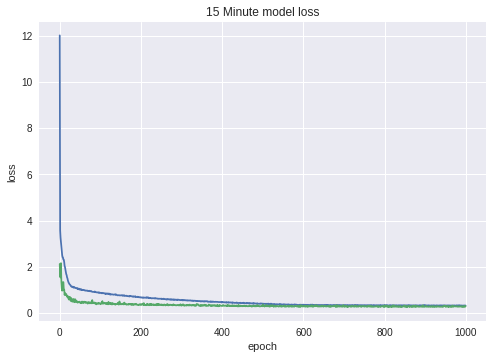

In [18]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('15 Minute model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 30 Minute Horizon

In [19]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_30min)))
trainY = Variable(torch.Tensor(np.array(trn_y_30min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_30min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_30min)))

testX = Variable(torch.Tensor(np.array(tst_x_30min)))
testY = Variable(torch.Tensor(np.array(tst_y_30min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_LSTM_30min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(y_pred, targets)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)

        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.36065593 val_loss: 1.24231420 
epoch: 20 | trn_loss: 1.56498158 val_loss: 0.89703644 
epoch: 30 | trn_loss: 1.29132837 val_loss: 0.83543187 
epoch: 40 | trn_loss: 1.18724523 val_loss: 0.65257890 
epoch: 50 | trn_loss: 1.14700331 val_loss: 0.66000306 
epoch: 60 | trn_loss: 1.11853154 val_loss: 0.61487379 
epoch: 70 | trn_loss: 1.07299087 val_loss: 0.59223706 
epoch: 80 | trn_loss: 1.03998768 val_loss: 0.59530754 
epoch: 90 | trn_loss: 0.99794327 val_loss: 0.57292881 
epoch: 100 | trn_loss: 0.96944455 val_loss: 0.56449691 
epoch: 110 | trn_loss: 0.95009890 val_loss: 0.54583643 
epoch: 120 | trn_loss: 0.92481661 val_loss: 0.56412476 
epoch: 130 | trn_loss: 0.90631901 val_loss: 0.54132247 
epoch: 140 | trn_loss: 0.90531419 val_loss: 0.58960502 
epoch: 150 | trn_loss: 0.87287657 val_loss: 0.53304285 
epoch: 160 | trn_loss: 0.86575891 val_loss: 0.54678723 
epoch: 170 | trn_loss: 0.84818253 val_loss: 0.57652885 
epoch: 180 | trn_loss: 0.83270588 val_loss: 0.49975720 
e

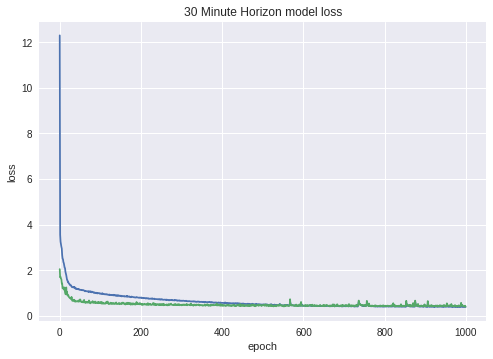

In [21]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('30 Minute Horizon model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## 45 Minute Horizon

In [22]:
num_corridor =  num_corridor       # number of corridors also the channel in NTC
hidden_size = 120        # lstm hidden_dim
num_layers = 2          # lstm layers
seq_length = 24
drop_prob = 0.5         # fully connected layer
batch_size = 50

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM(num_corridor, seq_length, hidden_size, num_layers)
model = model.to(device)

learning_rate =  0.001

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error

trainX = Variable(torch.Tensor(np.array(trn_x_45min)))
trainY = Variable(torch.Tensor(np.array(trn_y_45min)))

vldtX = Variable(torch.Tensor(np.array(vld_x_45min)))
vldtY = Variable(torch.Tensor(np.array(vld_y_45min)))

testX = Variable(torch.Tensor(np.array(tst_x_45min)))
testY = Variable(torch.Tensor(np.array(tst_y_45min)))

train_dataset = MyData(trainX, trainY)
val_dataset = MyData(vldtX, vldtY)
tst_dataset = MyData(testX, testY)

train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_loader = DataLoader(val_dataset, batch_size = batch_size)
tst_dataset = DataLoader(tst_dataset, batch_size = batch_size)

trn_loss, val_loss = [], []

start = time.time()

num_epochs = 1000

start = time.time()

# Train the model
for epoch in range(1, num_epochs + 1):

    ls = 0
    valid_ls = 0

    for i, train_batch in enumerate(train_loader):
        inputs, targets = train_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.train()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)

        ls += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_ls = ls/(i + 1)
    trn_loss.append(avg_ls)

    # Validating the model with current parameters

    for j, val_batch in enumerate(val_loader):
        inputs, targets = val_batch

        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        model.eval()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        valid_ls += loss.item()

    avg_valid_ls = valid_ls/(j + 1)

    if  len(val_loss) == 0 or avg_valid_ls < min(val_loss):

        filepath = f'/content/drive/MyDrive/CIS 545 Project Folder/Data Set/Stacked_LSTM_45min_epoch_{epoch}_loss_{avg_valid_ls}.pth'

        torch.save(model.state_dict(), filepath)
        
        mae_test,  rmse_test,  mape_test = 0, 0, 0

        for k, tst_batch in enumerate(tst_dataset):

            inputs, targets = tst_batch

            # Move tensors to the configured device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            model.eval()
            y_pred = model(inputs)

            y_pred = y_pred.cpu().detach().numpy()
            targets = targets.cpu().detach().numpy()

            # y_pred = sc.inverse_transform(y_pred)
            # targets = sc.inverse_transform(targets)   

            mae_test += mean_absolute_error(y_pred, targets)
            
            rmse_test += mean_squared_error(targets, y_pred, squared=False)

            mape_test += mean_absolute_percentage_error(targets, y_pred)


        mae_loss, rmse_loss, mape_loss = mae_test/(k+1), rmse_test/(k+1), mape_test/(k+1)
        # print("mae_loss, rmse_loss, mape_loss ", mae_loss, rmse_loss, mape_loss)

    val_loss.append(avg_valid_ls)

    if epoch % 10 == 0:
    
      print("epoch: {} | trn_loss: {:.8f} val_loss: {:.8f} ".format(epoch, trn_loss[-1], val_loss[-1]))

end = time.time()
print('time %.2f sec' % (end-start))
print("*"*100)

print("mae_loss, rmse_loss, mape_loss: ", mae_loss, rmse_loss, mape_loss)

epoch: 10 | trn_loss: 2.43964164 val_loss: 1.13495873 
epoch: 20 | trn_loss: 1.61085198 val_loss: 0.83694658 
epoch: 30 | trn_loss: 1.38079943 val_loss: 0.78853390 
epoch: 40 | trn_loss: 1.33722381 val_loss: 0.74553651 
epoch: 50 | trn_loss: 1.26592347 val_loss: 0.68596509 
epoch: 60 | trn_loss: 1.24112022 val_loss: 0.67361568 
epoch: 70 | trn_loss: 1.17993144 val_loss: 0.64703091 
epoch: 80 | trn_loss: 1.18650821 val_loss: 0.63151548 
epoch: 90 | trn_loss: 1.13592830 val_loss: 0.62382531 
epoch: 100 | trn_loss: 1.10180017 val_loss: 0.62544366 
epoch: 110 | trn_loss: 1.08105534 val_loss: 0.64424209 
epoch: 120 | trn_loss: 1.04201266 val_loss: 0.61852381 
epoch: 130 | trn_loss: 1.05680187 val_loss: 0.59205017 
epoch: 140 | trn_loss: 1.00804506 val_loss: 0.63868121 
epoch: 150 | trn_loss: 0.98113870 val_loss: 0.62597964 
epoch: 160 | trn_loss: 0.96180066 val_loss: 0.57213605 
epoch: 170 | trn_loss: 0.96369470 val_loss: 0.58197530 
epoch: 180 | trn_loss: 0.93639971 val_loss: 0.59271037 
e

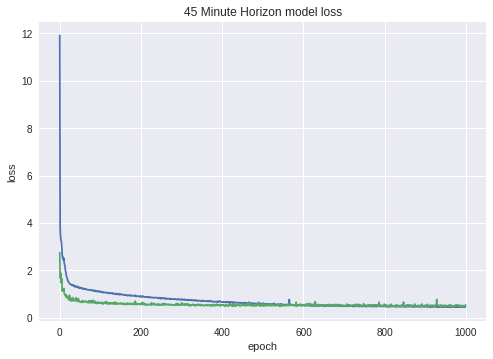

In [24]:
plt.plot(trn_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validating Loss")
plt.title('45 Minute Horizon model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()